<a href="https://colab.research.google.com/github/UiinKim/UiinKim/blob/main/%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 35.0 MB/s eta 0:00:00


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7dbf72147280>)

In [4]:
train_data=pd.read_table('ratings_train.txt')
test_data=pd.read_table('ratings_test.txt')

In [5]:
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
print(len(train_data))

150000


In [7]:
print(len(test_data))

50000


In [8]:
train_data.nunique()

id          150000
document    146182
label            2
dtype: int64

In [9]:
train_data.drop_duplicates(subset=['document'], inplace=True) #inplace=True 는 변경값을 그대로 저장하는 것이다.

In [10]:
print(len(train_data))

146183


<Axes: >

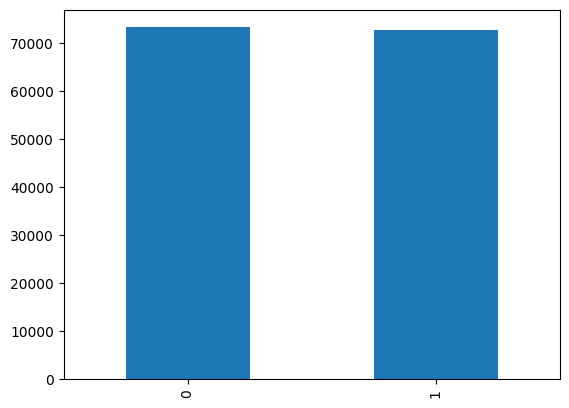

In [11]:
train_data['label'].value_counts().plot(kind='bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name='count')) #reset_index는 기존에 설정되어 있는 행 인덱스를 제거하고 데이터 열로 추가하는 방식

   label  count
0      0  73342
1      1  72841


In [13]:
train_data.isnull().any()

id          False
document     True
label       False
dtype: bool

In [14]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [15]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train_data=train_data.dropna(how='any') #how='any'로 존재하면 바로 제거.
print(train_data.isnull().any())

id          False
document    False
label       False
dtype: bool


In [17]:
print(len(train_data))

146182


In [18]:
#정규표현식으로 한글 외에 모두 제거
train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅑ-ㅣ가-힣]", "") #str.을 넣음으로써 일부라도 일치하면 바꾼다.
train_data[:5]

<ipython-input-18-cff868125665>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅑ-ㅣ가-힣]", "") #str.을 넣음으로써 일부라도 일치하면 바꾼다.


,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


In [19]:
train_data['document']=train_data['document'].str.replace('^ +', "") #공백이 존재한다면 ''으로 바꾼다.
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    790
label         0
dtype: int64


<ipython-input-19-08d6a8b2225f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document']=train_data['document'].str.replace('^ +', "") #공백이 존재한다면 ''으로 바꾼다.


In [20]:
train_data.dropna(how='any', inplace=True)
print(len(train_data))

145392


In [21]:
#test데이터 전처리
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document']=test_data['document'].str.replace('[^ㄱ-ㅎㅑ-ㅣ가-힣]','')
test_data['document']=test_data['document'].str.replace('^ +', "")
test_data.replace('',np.nan, inplace=True)
test_data.dropna(how='any', inplace=True)
print('전처리 후 테스트용 샘플의 수 : ', len(test_data))

<ipython-input-21-a05d9354f5da>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document']=test_data['document'].str.replace('[^ㄱ-ㅎㅑ-ㅣ가-힣]','')
<ipython-input-21-a05d9354f5da>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document']=test_data['document'].str.replace('^ +', "")


전처리 후 테스트용 샘플의 수 :  48852


In [22]:
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [23]:
okt=Okt()

In [24]:
X_train=[]
for sentence in tqdm(train_data['document']):
  tokenized_sentence=okt.morphs(sentence, stem=True) #norm은 문장을 정규화, stem은 어간을 추출
  stopwords_removed_sentence=[word for word in tokenized_sentence if not word in stopwords]
  X_train.append(stopwords_removed_sentence)

100%|██████████| 145392/145392 [1:11:43<00:00, 33.79it/s]


In [30]:
X_test=[]
for sentence in tqdm(test_data['document']):
  tokenized_sentence=okt.morphs(sentence, stem=True)
  stopwords_removed_sentence=[word for word in tokenized_sentence if not word in stopwords]
  X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [27:41<00:00, 29.40it/s]


In [33]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [34]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '좋다': 6, '다': 7, '너무': 8, '하': 9, '정말': 10, '재밌다': 11, '적': 12, '되다': 13, '같다': 14, '있다': 15, '만': 16, '진짜': 17, '않다': 18, '로': 19, '아니다': 20, '에서': 21, '내': 22, '평점': 23, '그': 24, '최고': 25, '인': 26, '나': 27, '연기': 28, '생각': 29, '스토리': 30, '점': 31, '게': 32, '이영화': 33, '드라마': 34, '감동': 35, '사람': 36, '만들다': 37, '고': 38, '요': 39, '나오다': 40, '아깝다': 41, '이런': 42, '지': 43, 'ㅋㅋ': 44, '보고': 45, '재미있다': 46, '배우': 47, '왜': 48, '감독': 49, '때': 50, '네': 51, '들다': 52, '하고': 53, '그냥': 54, '아': 55, '재미없다': 56, '시간': 57, '까지': 58, '못': 59, '중': 60, '것': 61, '지루하다': 62, '뭐': 63, '가다': 64, '재미': 65, '쓰레기': 66, '말': 67, '면': 68, '주다': 69, '본': 70, '모르다': 71, '작품': 72, '알다': 73, '더': 74, '오다': 75, '거': 76, '자다': 77, '그렇다': 78, '사랑': 79, '마지막': 80, '저': 81, '대': 82, '정도': 83, '화': 84, 'ㅠㅠ': 85, '이나': 86, '많다': 87, '완전': 88, 'ㅋㅋㅋ': 89, '처음': 90, '라': 91, 'ㅋ': 92, '안되다': 93, '개': 94, '액션': 95, '이렇게': 96, '주인공': 97, '니': 98, '최악': 99, '내용': 100, '느낌': 101, '싶다': 102

In [35]:
#등장 빈도수 3회 미만인 단어들이 차지하는 비율
threshold=3
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0

for key, value in tokenizer.word_counts.items():
  total_freq+=value
  if value<threshold:
    rare_cnt+=1
    rare_freq+=value

print('단어 집합의 크기 : ', total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수 : %s" %(threshold+1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율 : ", (rare_cnt/total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ", (rare_freq/total_freq)*100)

단어 집합의 크기 :  46454
등장 빈도가 4번 이하인 희귀 단어의 수 : 25440
단어 집합에서 희귀 단어의 비율 :  54.76385241313988
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  1.9738473855234449


In [36]:
#전체 단어 개수 중 빈도수가 2 이하인 단어 제거
#0번 패딩 토큰을 고려하여 +1
vocab_size=total_cnt-rare_cnt+1
print("단어 집합의 크기 : ", vocab_size)

단어 집합의 크기 :  21015


In [37]:
tokenizer=Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

In [38]:
print(X_train[:3])

[[9876, 11445, 17, 249, 661], [1062, 468, 45, 605, 1, 407, 1509, 28, 1077, 680, 18], [214, 1719, 569, 3847, 2, 226, 7]]


In [39]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

In [40]:
#각 샘플들의 길이가 0인 샘플들의 인덱스
drop_train=[index for index, sentences in enumerate(X_train) if len(sentence)<1]

In [41]:
#빈 데이터 제거
X_train=np.delete(X_train, drop_train, axis=0)
y_train=np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145392
145392


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰 데이터의 최대 길이 68
리뷰의 평균 길이 10.737454605480357


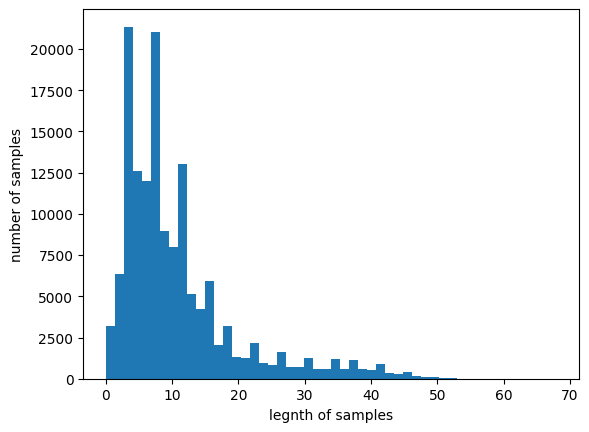

In [43]:
print("리뷰 데이터의 최대 길이", max(len(word) for word in X_train))
print("리뷰의 평균 길이", sum(map(len, X_train))/len(X_train))
plt.hist([list(len(review)for review in X_train)], bins=50)
plt.xlabel('legnth of samples')
plt.ylabel('number of samples')
plt.show()

In [44]:
#max_len 이하인 샘플의 비율이 몇%인지 확인하기
def below_threshold_len(max_len, nested_list):
  count=0
  for sentence in nested_list:
    if(len(sentence)<max_len):
      count+=1
  print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"%(max_len, count/len(nested_list)*100))

In [45]:
max_len=30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 93.95083635963464


In [46]:
X_train=pad_sequences(X_train, maxlen=max_len)
X_test=pad_sequences(X_test, maxlen=max_len)

In [47]:
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim=100
hidden_units=128

model=Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es=EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min')
mc=ModelCheckpoint('best_model.h5',monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history=model.fit(X_train, y_train, batch_size=64, callbacks=[es, mc], epochs=15, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - ETA: 0s - loss: 0.4148 - acc: 0.8074
Epoch 1: val_acc improved from -inf to 0.83256, saving model to best_model.h5
1818/1818 [==============================] - 56s 26ms/step - loss: 0.4148 - acc: 0.8074 - val_loss: 0.3779 - val_acc: 0.8326
Epoch 2/15
1818/1818 [==============================] - ETA: 0s - loss: 0.3511 - acc: 0.8468
Epoch 2: val_acc improved from 0.83256 to 0.84078, saving model to best_model.h5
1818/1818 [==============================] - 18s 10ms/step - loss: 0.3511 - acc: 0.8468 - val_loss: 0.3623 - val_acc: 0.8408
Epoch 3/15
1818/1818 [==============================] - ETA: 0s - loss: 0.3252 - acc: 0.8611
Epoch 3: val_acc improved from 0.84078 to 0.84700, saving model to best_model.h5
1818/1818 [==============================] - 15s 8ms/step - loss: 0.3252 - acc: 0.8611 - val_loss: 0.3467 - val_acc: 0.8470
Epoch 4/15
1818/1818 [==============================] - ETA: 0s - loss: 0.3021 - acc: 0.8733
Epoch 4: val_a

In [50]:
loaded_model=load_model('best_model.h5')
print("\n 테스트 정확도 : %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 6s 3ms/step - loss: 0.3478 - acc: 0.8462

 테스트 정확도 : 0.8462


In [51]:
with open('tokenizer.pickle', 'wb') as handle: #tokenizer.pickle에 저장한다.
  pickle.dump(tokenizer, handle)
with open('tokenizer.pickle', 'rb') as handle: #위에서 저장한 파일을 로드한다.
  tokenizer=pickle.load(handle)

In [61]:
#새로운 리뷰를 가져와서 예측한다.
#전처리부터 진행
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence) #r은 raw를 뜻한다.
  tokenized_sentence=okt.morphs(new_sentence, stem=True)
  stop_removed_sentence=[word for word in tokenized_sentence if not word in stopwords]
  encoded=tokenizer.texts_to_sequences([stop_removed_sentence])
  paded=pad_sequences(encoded, maxlen=max_len)
  score=float(loaded_model.predict(paded))
  if(score>0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score*100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1-score)*100))

In [64]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 19ms/step
80.34% 확률로 긍정 리뷰입니다.



In [63]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 63ms/step
95.76% 확률로 부정 리뷰입니다.

